# HW1. Байесовская генерация и автоэнкодер для детекции аномалий
### Влада Пухкало

In [2]:
import pandas
import os
from IPython.display import Image
from itertools import product
import math
import numpy as np
from PIL import Image
from collections import defaultdict
import random
import io
import zipfile

In [3]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import tqdm

## Задание 1: Байесовская генерация стилей

1) Использует данные о стилях

2) На основе формулы MLE и формулы Байеса о полной вероятности генерировать случайный стиль

3) Так же вернуть вероятность генерации данного стиля

In [ ]:
styles = {
    'прическа':[
        'нет волос',
        'длинные в пучок',
        'длинные волнистые',
        'длинные прямые',
        'короткая волнистые',
        'короткая прямые',
        'короткая курчавые'
    ],
    'цвет волос':[
        'черный',
        'блонд',
        'каштановый',
        'пастельный розовый',
        'рыжий',
        'серебристо серый',
    ],
    'аксесуар':[
        'нет очков',
        'круглые очки',
        'солнцезащитные очки',
    ],
    'одежда':[
        'худи',
        'комбинезон',
        'футболка с круглым вырезом',
        'футболка с V-вырезом',
    ],
    'цвет одежды':[
        'черный',
        'синий',
        'серый',
        'зеленый',
        'оранжевый',
        'розовый',
        'красный',
        'белый'
    ],
}

In [ ]:
param_counts = 1
for s in styles.values():
    param_counts *= len(s)
param_counts

4032

In [ ]:
styles_count = {
    'прическа':[
        7,
        0,
        1,
        23,
        1,
        11,
        7
    ],
    'цвет волос':[
        7,
        6,
        2,
        3,
        8,
        24,
    ],
    'аксесуар':[
        11,
        22,
        17,
    ],
    'одежда':[
        7,
        18,
        19,
        6,
    ],
    'цвет одежды':[
        4,
        5,
        6,
        8,
        6,
        8,
        7,
        6
    ],
}

In [ ]:
sum_dict = {}
for k in styles_count.keys():
    summ = 0
    for s in styles_count[k]:
        summ += s
    sum_dict[k] = summ
    print(k, summ)

прическа 50
цвет волос 50
аксесуар 50
одежда 50
цвет одежды 50


In [ ]:
# составляем список всех возможных комбинаций
def find_combinations(*lists):
    combinations = list(product(*lists))
    combinations = [dict(zip(styles.keys(), comb)) for comb in combinations]
    return combinations

all_styles = find_combinations(*styles.values())
print(len(all_styles))

4032


In [ ]:
styles_count2 = {f:dict(zip(styles[f], styles_count[f])) for f in styles.keys()}
styles_count2['прическа']

{'нет волос': 7,
 'длинные в пучок': 0,
 'длинные волнистые': 1,
 'длинные прямые': 23,
 'короткая волнистые': 1,
 'короткая прямые': 11,
 'короткая курчавые': 7}

In [ ]:
# для каждого стиля научимся считать вероятность

def get_feature_prob(feature, val):
    return (styles_count2[feature][val] + 1)/(sum_dict[feature] + len(styles[feature])) # со сглаживанием

def get_style_prob(style):
  probs = [get_feature_prob(f,v) for f,v in style.items()]
  # print(probs)
  return math.prod(probs)

In [ ]:
get_style_prob({'прическа': 'нет волос',
              'цвет волос': 'черный',
              'аксесуар': 'нет очков',
              'одежда': 'худи',
              'цвет одежды': 'синий'})

6.957319562188924e-05

In [ ]:
#список вероятностей, соответсвующий стилям
all_style_probs = [get_style_prob(style) for style in all_styles]
print(0 in all_style_probs)

False


In [ ]:
# генератор

class ProbabilityGenerator:
    def __init__(self, options, probabilities):
        self.options = options
        self.probabilities = probabilities

    def generate(self):
        choice = np.random.choice(self.options, p=self.probabilities)
        index = self.options.index(choice)
        probability = self.probabilities[index]
        return choice, probability

generator = ProbabilityGenerator(all_styles, all_style_probs)
result = generator.generate()
result

({'прическа': 'нет волос',
  'цвет волос': 'серебристо серый',
  'аксесуар': 'солнцезащитные очки',
  'одежда': 'комбинезон',
  'цвет одежды': 'белый'},
 0.0009036362321983661)

In [ ]:
#нагенерим 5 стилей
print(*[generator.generate() for i in range(5)], sep = '\n\n')

({'прическа': 'короткая прямые', 'цвет волос': 'серебристо серый', 'аксесуар': 'солнцезащитные очки', 'одежда': 'худи', 'цвет одежды': 'красный'}, 0.0006522487089552116)

({'прическа': 'длинные прямые', 'цвет волос': 'серебристо серый', 'аксесуар': 'нет очков', 'одежда': 'комбинезон', 'цвет одежды': 'белый'}, 0.0018072724643967326)

({'прическа': 'длинные прямые', 'цвет волос': 'черный', 'аксесуар': 'солнцезащитные очки', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'розовый'}, 0.0011740476761193809)

({'прическа': 'короткая волнистые', 'цвет волос': 'серебристо серый', 'аксесуар': 'солнцезащитные очки', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'розовый'}, 0.00030574158232275544)

({'прическа': 'длинные прямые', 'цвет волос': 'блонд', 'аксесуар': 'круглые очки', 'одежда': 'футболка с круглым вырезом', 'цвет одежды': 'черный'}, 0.0007292502926513131)


## Задание 2. Байесовская генерация аватаров

1) Используя в качестве фичей пиксели изображений аватаров (см папку avatars) написать генератор изображений, который генерирует новый аватар

2) Генератор выбирает значение каждого канала каждого пикселя используя распределение вероятностей, полученных на основе изображений avatars;

3) генерация так же осуществляется с помощью MLE

4) Выложить в репозиторий 5 сгенерированных аватаров

In [ ]:
Image.open('/content/avatars/avataaars (10).png').size

(528, 560)

In [ ]:
#считаем встречаемость значений каждого канала каждого пикселя
def get_pixel_сhanel_occurrences(directory_path):

    occurrences = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path)]

    for image_path in image_paths:
        with Image.open(image_path) as img:
            pixels = img.load()
            width, height = img.size
            for x in range(width):
                for y in range(height):
                    pixel_value = pixels[x, y]
                    for channel, value in enumerate(pixel_value):
                        occurrences[(x, y)][channel][value] += 1

    return occurrences

directory_path = '/content/avatars'
occurrences = get_pixel_сhanel_occurrences(directory_path)

In [ ]:
occurrences[(160,160)][0]

defaultdict(int,
            {248: 1,
             106: 1,
             174: 2,
             255: 1,
             44: 1,
             169: 1,
             237: 1,
             111: 1,
             56: 1,
             165: 1})

In [ ]:
def get_pixel_сhanel_probabilities(directory_path):

    occurrences = get_pixel_сhanel_occurrences(directory_path)

    image_paths = [f for f in os.listdir(directory_path)]
    num_images = len(image_paths)

    probabilities = {}
    for pixel, channels in occurrences.items():
        probabilities[pixel] = {}
        for channel, values in channels.items():
            probabilities[pixel][channel] = {}
            for value, count in values.items():
                probabilities[pixel][channel][value] = count / num_images

    return probabilities

In [ ]:
probabilities = get_pixel_сhanel_probabilities(directory_path)

In [ ]:
probabilities[(160,160)][0]

{248: 0.09090909090909091,
 106: 0.09090909090909091,
 174: 0.18181818181818182,
 255: 0.09090909090909091,
 44: 0.09090909090909091,
 169: 0.09090909090909091,
 237: 0.09090909090909091,
 111: 0.09090909090909091,
 56: 0.09090909090909091,
 165: 0.09090909090909091}

In [ ]:
class ImageGenerator:
    def __init__(self, directory_path):

        self.probabilities = get_pixel_сhanel_probabilities(directory_path)
        self.directory_path = directory_path

    def generate_image(self):

        first_image_path = next((os.path.join(self.directory_path, f) for f in os.listdir(self.directory_path)), None)
        with Image.open(first_image_path) as img:
            width, height = img.size

        new_image = Image.new('RGBA', (width, height))

        for x in range(width):
            for y in range(height):
                pixel_probabilities = self.probabilities.get((x, y), {})
                pixel_values = [0, 0, 0, 255]
                for channel in range(4):
                    channel_values, channel_probabilities = zip(*pixel_probabilities.get(channel, {}).items()) if pixel_probabilities.get(channel, {}) else ([0], [1])
                    pixel_values[channel] = random.choices(channel_values, weights=channel_probabilities, k=1)[0]
                new_image.putpixel((x, y), tuple(pixel_values))

        return new_image


In [ ]:
image_generator = ImageGenerator(directory_path)

In [ ]:
images = [image_generator.generate_image() for i in range(5)]

total_width = sum(image.width for image in images)
max_height = max(image.height for image in images)

combined_image = Image.new('RGBA', (total_width, max_height))

current_x = 0
for image in images:
    combined_image.paste(image, (current_x, 0))
    current_x += image.width

combined_image.show()

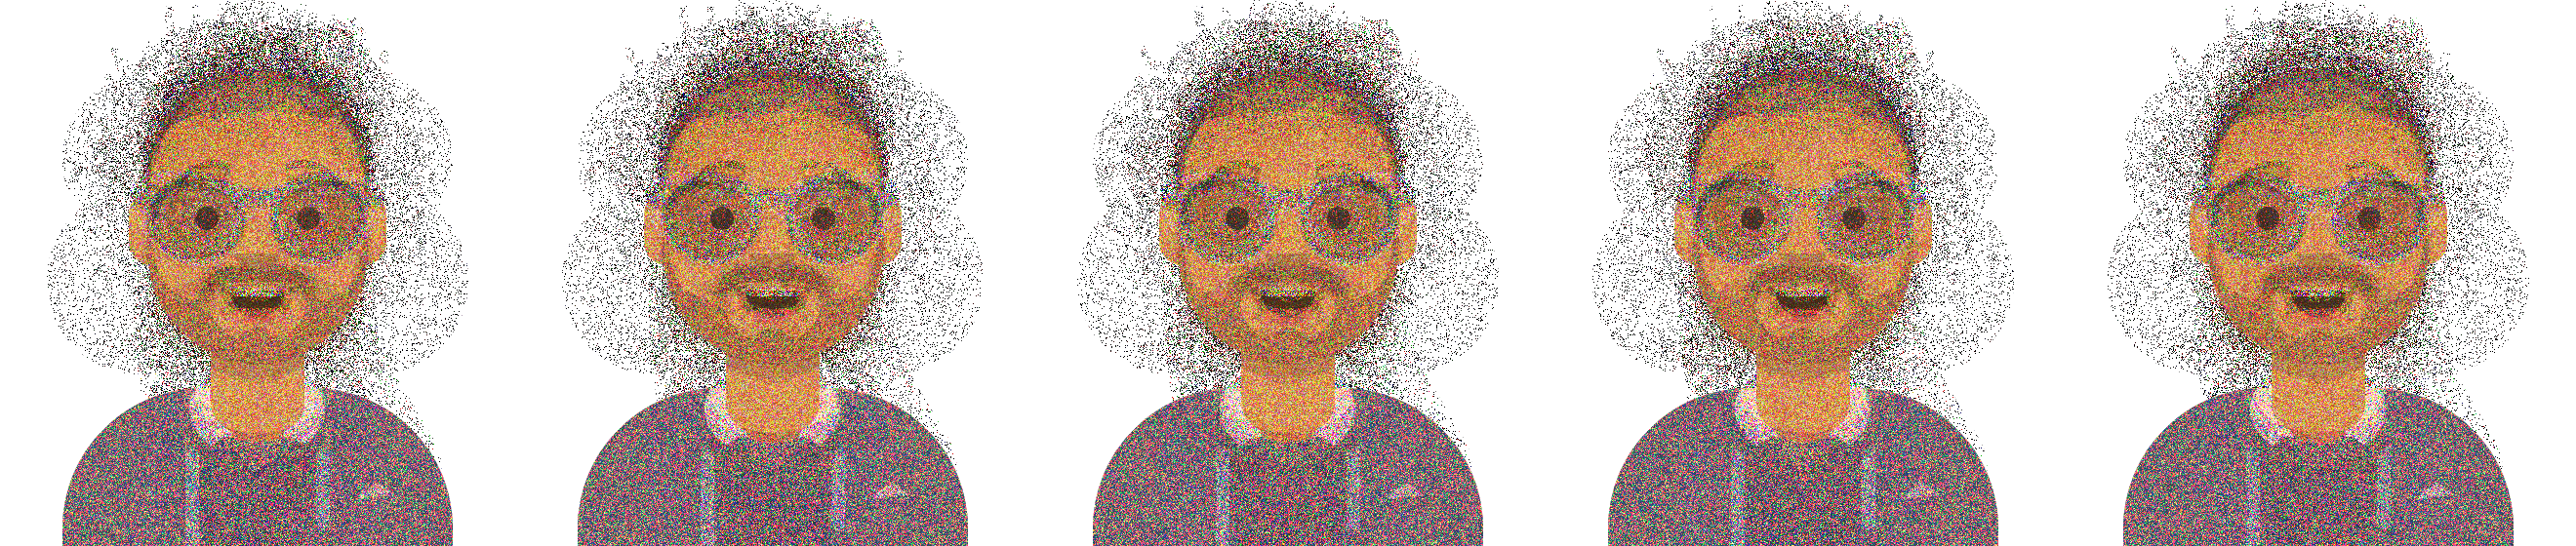

In [ ]:
combined_image

## Задание 3: автоэкодер

1) Имплементировать или найти автоэкодер (можно для старта взять пример из лекции по автоэнкодерам)

2) Обучаем автоэнкодер на не_проливах (dataset\train)

3) Если через такой автоэнкодер прогнать изображение пролива, то MSE между входным изображением и выходным будет больше, чем если прогнать изображение без пролива. Следовательно, если определить некторое пороговое значение MSE, можно классифицировать изображение на классы пролив\не_пролив. Если MSE между входной картинкой и выходной больше фиксированного порога, то на изображении пролив.

4) В качестве loss функции используем MSE (как минимум для baseline)

5) Для определения порога используем изображения из dataset\proliv

6) Пишем метод классификации лунок

7) На изображениях из dataset\test тестируем качество. Считаем True_positive_rate и True_negative_rate.

### Готовим данные

In [4]:
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
directory = '/content/dataset/train'

unique_sizes = set()
summ = 0

for filename in os.listdir(directory):
      filepath = os.path.join(directory, filename)
      with Image.open(filepath) as img:
          size = img.size
          summ += 1
          unique_sizes.add(size)

# for size in unique_sizes:
#     print(size)
print(summ)

10000


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = read_image(img_path)
        image = image.float()/ 255.0
        if self.transform:
            image = self.transform(image)
        return image

train_directory = "/content/dataset/train"
proliv_directory = "/content/dataset/proliv"

transform = transforms.Compose([
    transforms.Resize((50,30)),
])

train_data = DataLoader(CustomImageDataset(img_dir=train_directory, transform = transform),
                   batch_size=8, shuffle=True)
proliv = DataLoader(CustomImageDataset(img_dir=proliv_directory, transform = transform),
                   batch_size=8, shuffle=True)


In [7]:
for x in train_data:
    print(x.size())
    break

torch.Size([8, 3, 50, 30])


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Обучение

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.linear = nn.Linear(64*7*4, latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dims, 64 * 7 * 4)
        self.conv_trans1 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.conv_trans2 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.conv_trans3 = nn.Conv2d(16, 3, kernel_size=3, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 64, 7, 4)
        z = F.relu(self.conv_trans1(z))
        z = F.relu(self.conv_trans2(z))
        z = torch.sigmoid(self.conv_trans3(z))
        return z

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_history = []

    for epoch in tqdm.tqdm(range(epochs)):
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_history.append(loss.item())
    return autoencoder, loss_history

In [13]:
latent_dims = 2
vae = Autoencoder(latent_dims).to(device) # GPU
vae, loss_history = train(vae, train_data, epochs = 5)

100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


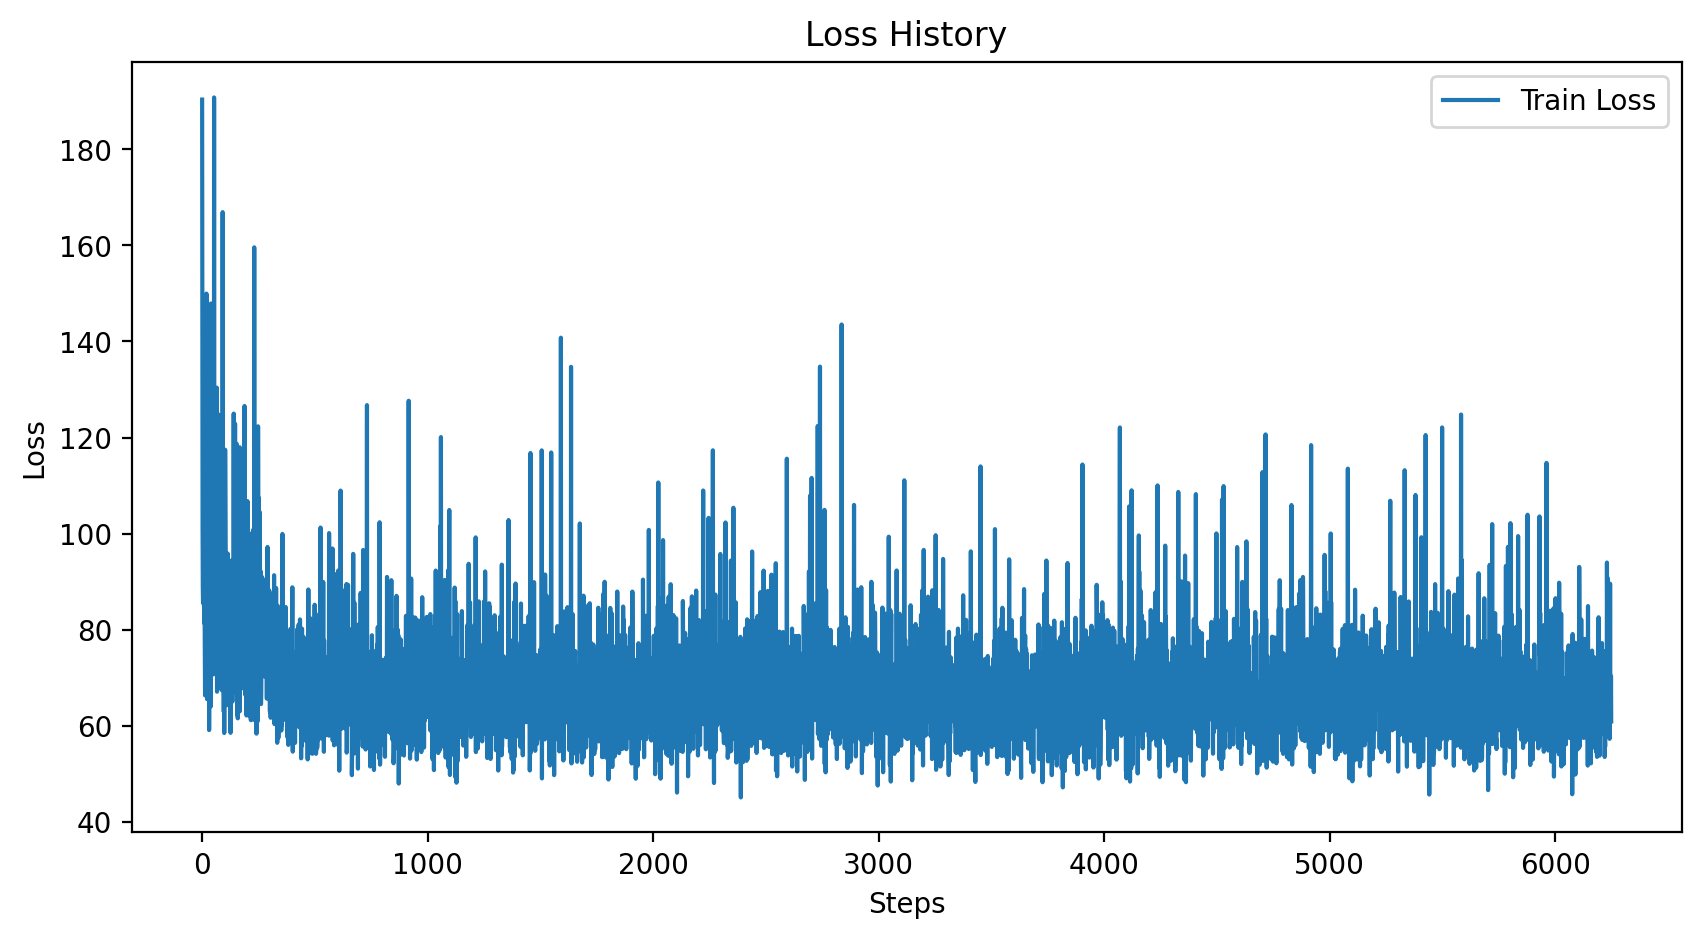

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.show()

### Подбираем трэшхолд для mse

In [15]:
vae.eval()
total_mse_normal = 0.0
total_count_normal = 0
max_mse_normal = 0.0
min_mse_normal = float('inf')

# Вычисляем cтатистики MSE для нормальных образцов из train_data
for x in train_data:
    x = x.to(device)
    with torch.no_grad():
        x_hat = vae(x)
    mse = ((x - x_hat)**2).sum()
    total_mse_normal += mse.item() * x.size(0)
    total_count_normal += x.size(0)
    max_mse_normal = max(max_mse_normal, mse.max().item())
    min_mse_normal = min(min_mse_normal, mse.min().item())

print(f"Максимальная MSE для нормальных образцов: {max_mse_normal}")
print(f"Минимальная MSE для нормальных образцов: {min_mse_normal}")

average_mse_normal = total_mse_normal / total_count_normal
print(f"Средняя MSE для нормальных образцов: {average_mse_normal}")

print()

total_mse_anomaly = 0.0
total_count_anomaly = 0
max_mse_anomaly = 0.0
min_mse_anomaly = float('inf')

# Вычисляем статистики MSE для аномальных образцов из proliv
for x in proliv:
    x = x.to(device)
    with torch.no_grad():
        x_hat = vae(x)
    mse = ((x - x_hat)**2).sum()
    total_mse_anomaly += mse.item() * x.size(0)
    total_count_anomaly += x.size(0)
    max_mse_anomaly = max(max_mse_anomaly, mse.max().item())
    min_mse_anomaly = min(min_mse_anomaly, mse.min().item())

print(f"Максимальная MSE для аномальных образцов: {max_mse_anomaly}")
print(f"Минимальная MSE для аномальных образцов: {min_mse_anomaly}")

average_mse_anomaly = total_mse_anomaly / total_count_anomaly
print(f"Средняя MSE для аномальных образцов: {average_mse_anomaly}")


Максимальная MSE для нормальных образцов: 129.26156616210938
Минимальная MSE для нормальных образцов: 47.21776580810547
Средняя MSE для нормальных образцов: 67.05609342956544

Максимальная MSE для аномальных образцов: 229.04913330078125
Минимальная MSE для аномальных образцов: 60.457889556884766
Средняя MSE для аномальных образцов: 206.8165600764287


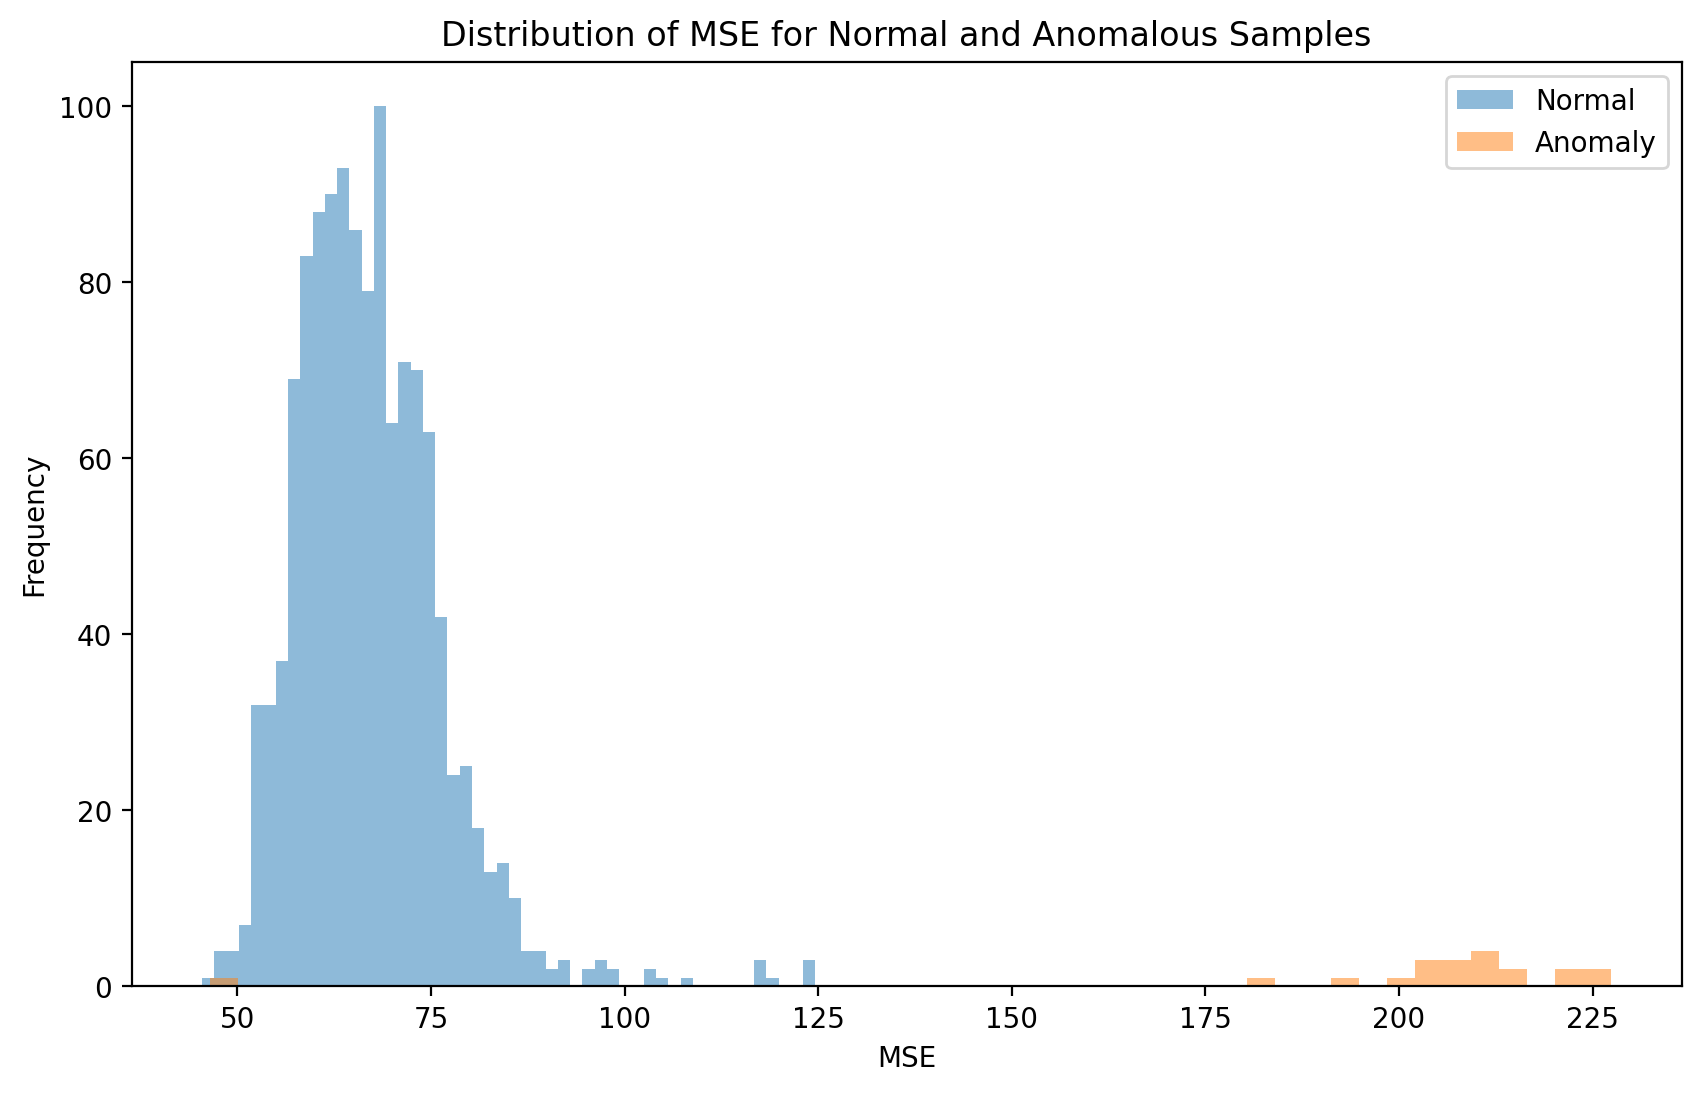

In [21]:
import matplotlib.pyplot as plt

vae.eval()

# Списки для хранения значений MSE
mse_normal = []
mse_anomaly = []

# Вычисляем MSE для нормальных образцов
for x in train_data:
    x = x.to(device)
    with torch.no_grad():
        x_hat = vae(x)
    mse_batch = ((x - x_hat)**2).sum().cpu().numpy()
    mse_normal.append(mse_batch)

# Вычисляем MSE для аномальных образцов
for x in proliv:
    x = x.to(device)
    with torch.no_grad():
        x_hat = vae(x)
    mse_batch = ((x - x_hat)**2).sum().cpu().numpy()
    mse_anomaly.append(mse_batch)

# гистограммы
plt.figure(figsize=(10, 6))
plt.hist(mse_normal, bins=50, alpha=0.5, label='Normal')
plt.hist(mse_anomaly, bins=50, alpha=0.5, label='Anomaly')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of MSE for Normal and Anomalous Samples')
plt.legend()
plt.show()

In [22]:
import torch
import torch.nn.functional as F

def calculate_precision_recall(autoencoder, normal_loader, anomaly_loader, threshold):
    autoencoder.eval()
    tp = 0  # True Positive
    fp = 0  # False Positive
    fn = 0  # False Negative

    for x in normal_loader:
        x = x.to(device)
        with torch.no_grad():
            x_hat = autoencoder(x)
        mse = ((x - x_hat)**2).sum()
        fp += torch.sum(mse > threshold).item()  # Если MSE больше трешхолда, классифицируем как аномалию

    for x in anomaly_loader:
        x = x.to(device)
        with torch.no_grad():
            x_hat = autoencoder(x)
        mse = ((x - x_hat)**2).sum()
        tp += torch.sum(mse > threshold).item()  # Если MSE больше трешхолда, классифицируем как аномалию
    fn = len(anomaly_loader.dataset) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2*(precision*recall)/(precision+recall)

    return precision, recall, f1


In [23]:
calculate_precision_recall(vae, train_data, proliv, 150)

(1.0, 0.12337662337662338, 0.21965317919075145)

100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


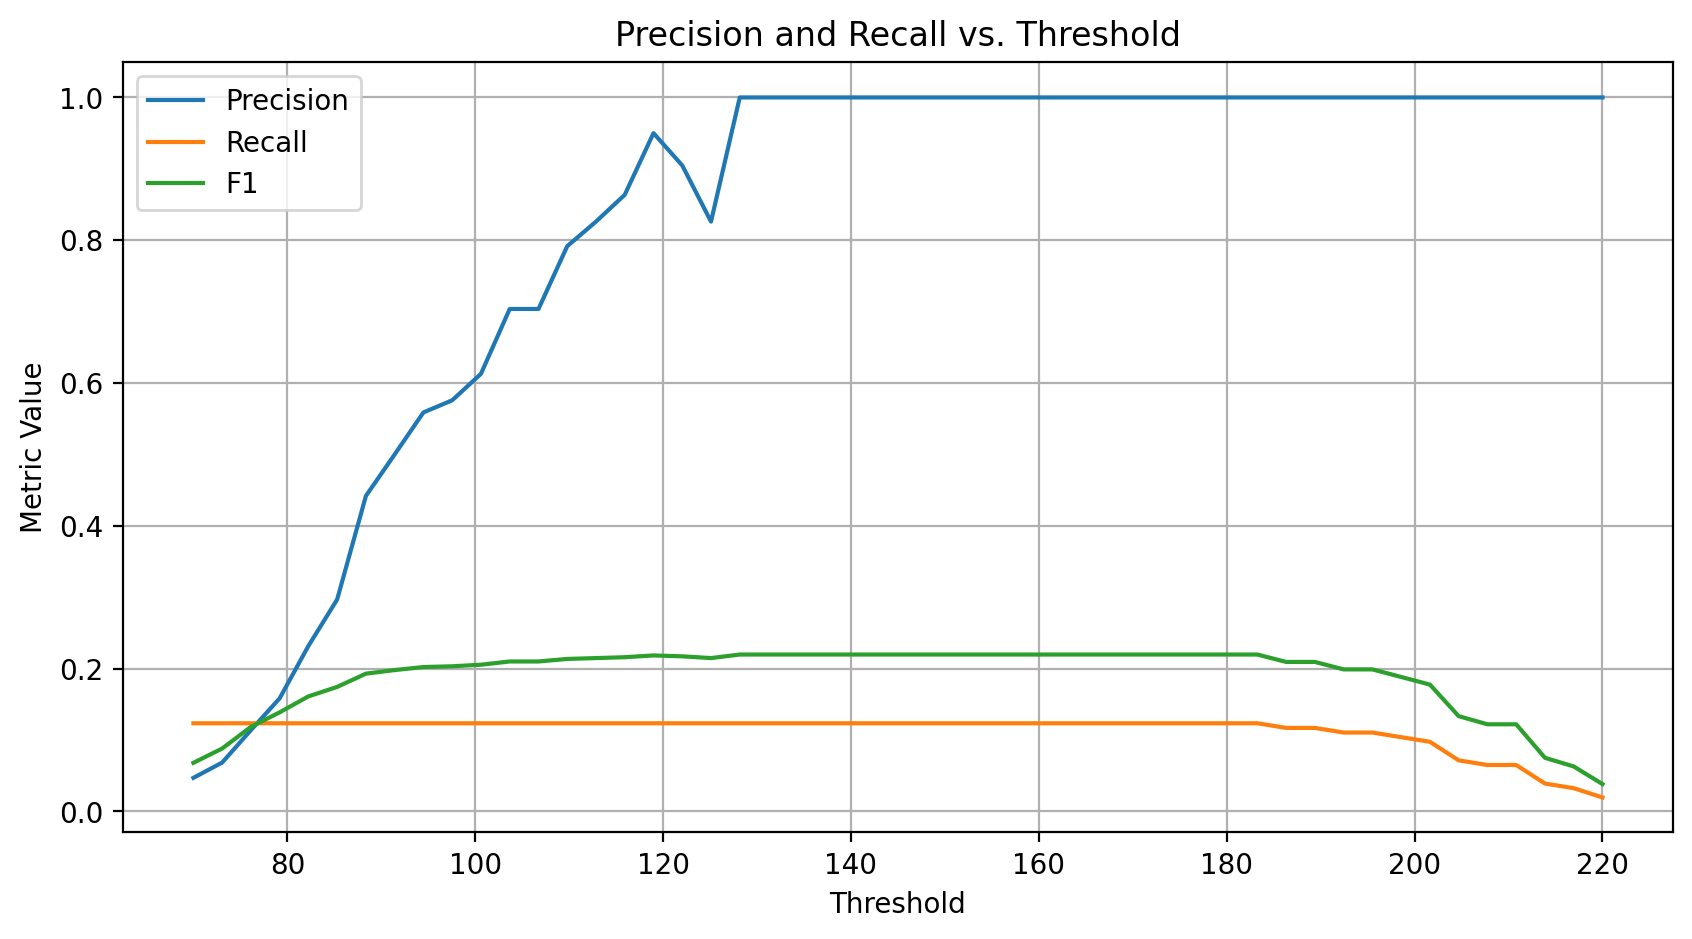

In [24]:
thresholds = np.linspace(70, 220, 50)

precisions = []
recalls = []
f1s = []

# Вычисляем precision и recall для каждого значения трешхолда
for threshold in tqdm.tqdm(thresholds):
    precision, recall, f1 = calculate_precision_recall(vae, train_data, proliv, threshold)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

**ИТОГ: лучшее значение для трэшхолда - любое от 125 до 180. Выберем 130.**

### Тестируем на dataset/test

In [25]:
# Загрузка меток из файла
def load_annotations(annotation_file):
    annotations = {}
    with open(annotation_file, 'r') as f:
        for line in f:
            img_name, label = line.strip().split()
            annotations[img_name] = int(label)
    return annotations

annotation_file = "/content/dataset/test/test_annotation.txt"
annotations = load_annotations(annotation_file)


In [27]:
class CustomTestDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.annotations = annotations
        self.img_names = list(annotations.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = read_image(img_path)
        image = image.float() / 255.0
        if self.transform:
            image = self.transform(image)
        label = self.annotations[img_name]
        return image, label

transform = transforms.Compose([
    transforms.Resize((50,30)),
])

test_directory = "/content/dataset/test/imgs"

test_data = DataLoader(CustomTestDataset(img_dir=test_directory, annotations=annotations,
                                          transform=transform), batch_size=8, shuffle=True)

In [38]:
# Вычисление метрик
tp, fp, fn, tn = 0, 0, 0, 0
threshold = 130

vae.eval()
for x, labels in test_data:
    x = x.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        x_hat = vae(x)
    mse = ((x - x_hat)**2).sum()
    preds = (mse > threshold).int()

    tp += ((preds == 1) & (labels == 1)).sum().item()
    fp += ((preds == 1) & (labels == 0)).sum().item()
    fn += ((preds == 0) & (labels == 1)).sum().item()
    tn += ((preds == 0) & (labels == 0)).sum().item()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = fp/(fp+tn)
fnr = fn/(fn+tp)


print(f"FPR: {fpr}, FNR: {fnr}, F1:{f1}, precision:{precision}, recall:{recall}", sep = '\n')


FPR: 0.10286493860845838, FNR: 0.7596899224806202, F1:0.1154562383612663, precision:0.07598039215686274, recall:0.24031007751937986
